In [205]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.special import gamma
from scipy.optimize import differential_evolution

from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages

In [206]:
plt.style.use('ggplot')

In [207]:
df = pd.read_csv("csv_output/p1730_2022.csv", converters={
    "AmplKSM": eval, "hSM": eval, "nTrackSMX": eval, "nTrackSMY": eval, "nTrackSM": eval,
    "hSM0": eval, "nTrackSMX0": eval, "nTrackSMY0": eval, "nTrackSM0": eval,
    "EdepCntSCT": eval, "EdepDetNE": eval, "TimDetNE": eval, "EdepStNE": eval, "TimStNE": eval
})

In [208]:
df.head(4)

,N_event,NRUN,NEVENT,PART0,E0,Teta,Fi,XAxisShift,YAxisShift,H1INT,...,hSM0,nTrackSMX0,nTrackSMY0,nTrackSM0,EdepCntSCT,EdepDetNE,TimDetNE,EdepStNE,TimStNE,marker
0,0.0,173000.0,1.0,14.0,100000000.0,30.0,53.163406,21.254372,60.104460,3549455.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[484.4850158691406, 516.8804321289062, 411.3...","[[[[136352.890625, 136258.109375, 136239.4375,...","[[1755.4146728515625, 1280.5128173828125, 975....","[[[136375.296875, 136243.75, 136237.4375, 1362...",-1.0
1,0.0,173001.0,1.0,14.0,100000000.0,30.0,118.852844,0.967100,53.281273,1595547.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[1688.9930419921875, 1648.3756103515625, 143...","[[[[61049.18359375, 60952.125, 60910.125, 6092...","[[6706.82470703125, 5095.81103515625, 3485.858...","[[[63138.34765625, 60913.1015625, 60909.011718...",-1.0
2,0.0,173002.0,1.0,14.0,100000000.0,30.0,286.241000,-19.320170,46.458084,2439109.5,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[1179.007080078125, 1364.9500732421875, 1572...","[[[[93722.7109375, 93293.046875, 93289.6015625...","[[5341.71337890625, 4321.70556640625, 2836.470...","[[[104192.484375, 93290.578125, 93289.4296875,...",-1.0
3,0.0,173003.0,1.0,14.0,100000000.0,30.0,65.182830,40.142555,39.634895,1626964.9,...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0....","[[[1088.6395263671875, 1051.98583984375, 1205....","[[[[63131.47265625, 62198.55078125, 62169.4257...","[[4219.66259765625, 2415.139892578125, 2878.16...","[[[63131.47265625, 62172.51171875, 62168.00781...",-1.0


In [209]:
coordinates_df = pd.read_csv('../data/coordinates.csv')
coordinates_df.head(2)

,cluster,station,X,Y,Z
0,1,1.1,-25.359,5.885,-6.684
1,1,1.2,-37.609,5.885,-6.684


## положение оси $X_0, Y_0$ 
$$
X_0 = \frac{\sum X_i \cdot m_i}{m_i}
$$

$$
Y_0 = \frac{\sum Y_i \cdot m_i}{m_i} 
$$

In [210]:
df['NeNKGlong'].head(5)

0     4734297.0
1    15149074.0
2     6574410.0
3    18120796.0
4    11086829.0
Name: NeNKGlong, dtype: float64

In [211]:
df['sNKGlong'].head(5)

0    1.375637
1    1.288089
2    1.355909
3    1.252712
4    1.309551
Name: sNKGlong, dtype: float64

In [273]:
j_event = 6

In [274]:
E_1_event = df['EdepStNE'].iloc[j_event]

theta = df['Teta'].iloc[j_event]
phi = df['Fi'].iloc[j_event]

X0_corsika = df['XAxisShift'].iloc[j_event]
Y0_corsika = df['YAxisShift'].iloc[j_event]

Ne_corsika = df['NeNKGlong'].iloc[j_event]
s_corsika = df['sNKGlong'].iloc[j_event]

X = coordinates_df['X']
Y = coordinates_df['Y']
Z = coordinates_df['Z']

In [275]:
e_list = []
for i_cluster, cluster in enumerate(E_1_event):
    for j_station, value in enumerate(cluster):
        e_list.append(
            {'cluster': i_cluster+1, 'station': j_station+1, 'E': value})

E_stations = pd.DataFrame(e_list)
E_stations.head(2)

,cluster,station,E
0,1,1,23450.158203
1,1,2,13267.817383


In [276]:
X0 = np.sum(X * E_stations['E']) / np.sum(E_stations['E'])
Y0 = np.sum(Y * E_stations['E']) / np.sum(E_stations['E'])

In [277]:
print(X0, Y0)

-20.086855810713967 19.777732481506902


In [278]:
Z0 = -18

## $r$
Ось ШАЛ:

$
 \begin{cases}
X = X_0 + ct \cos{\phi}\sin{\theta} \\
Y = Y_0 + ct \sin{\phi}\sin{\theta} \\
Z = Z_0 + ct \cos{\theta}
 \end{cases}
$

Пусть станция имеет координаты $(X_s,Y_s,Z_s)$

$
r = \frac{|\vec{v} \times (P - P_0)|}{|\vec{v}|}
$

$ P_0​=(X_0​,Y_0​,Z_0​) $ — точка на оси ШАЛ

$ P = (X_s,Y_s,Z_s) $ — координаты станции

$ \vec{v}=(\cos⁡{\phi}\sin{\theta},\sin⁡{\phi}\sin⁡{\theta}, \cos⁡{\theta})$ — направляющий вектор оси ШАЛ


In [279]:
def compute_r(X0, Y0, Z0, theta, phi, coordinates_df):
    theta = np.radians(theta)
    phi = np.radians(phi)

    v = np.array([np.cos(phi) * np.sin(theta), np.sin(phi)
                 * np.sin(theta), np.cos(theta)])

    P0 = np.array([X0, Y0, Z0])

    P = np.vstack(
        (coordinates_df['X'], coordinates_df['Y'], coordinates_df['Z'])).T

    cross_product = np.cross(P - P0, v)

    r = np.linalg.norm(cross_product, axis=1) / np.linalg.norm(v)

    return r

In [280]:
r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)

## $\rho$

$ N_e = \frac{E}{8.2 \text{MeV}} $

$ S = 0.8 \times 0.8 \times 4 $ 

$ \rho = \frac{N_e}{S} $


In [281]:
N_e = E_stations['E'] / 8.2
S = 0.8 * 0.8 * 4
rho = N_e/S

In [282]:
rho_log = np.log10(rho)

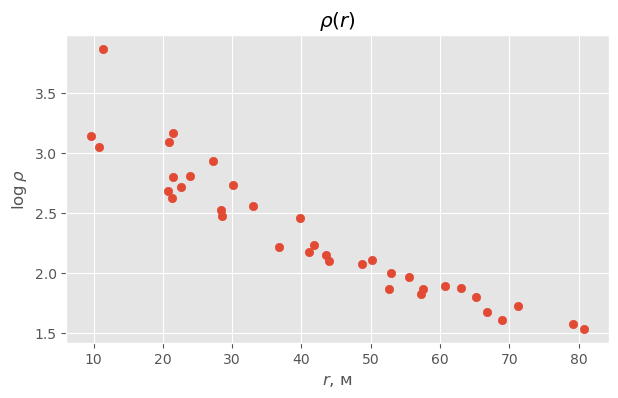

In [283]:
plt.figure(figsize=(7, 4))
plt.scatter(r, rho_log)
plt.xscale("linear")
# plt.yscale("log")
plt.xlabel(r'$r$, м')
plt.ylabel(r'$\log{\rho}$')
plt.title(r'$\rho(r)$')
plt.show()

## функция пространственного распределения электронов

$ \rho(r) = \frac{N_e}{2\pi r_m^2} (\frac{r}{r_m})^{s-2}(1+\frac{r}{r_m})^{s-4.5} \frac{\Gamma(4.5-s)}{\Gamma(s)\Gamma(4.5-2s)}$

$ r_m = 79$

In [284]:
def rho_model(r, Ne, s, r_m=78):
    term1 = Ne / (2 * np.pi * r_m**2)
    term2 = (r / r_m) ** (s - 2)
    term3 = (1 + r / r_m) ** (s - 4.5)
    term4 = gamma(4.5 - s) / (gamma(s) * gamma(4.5 - 2 * s))
    return term1 * term2 * term3 * term4

In [285]:
import math

In [286]:
def loss_function(params, coordinates_df, rho, theta, phi, Z0):
    X0, Y0, Ne, s = params
    r = compute_r(X0, Y0, Z0, theta, phi, coordinates_df)
    rho_calc = rho_model(r, Ne, s)
    return np.mean((rho_calc - rho) ** 2)

In [287]:
print(
    f'\nмедианное X0 = {np.median(df['XAxisShift'])}, '
    f'\nмедианное Y0 = {np.median(df['YAxisShift'])}, '
    f'\nмедианное s = {np.median(df['sNKGlong'])}, '
    f'\nмедианное Ne = {np.median(df['NeNKGlong'])}'
)


медианное X0 = 2.3667251, 
медианное Y0 = -1.91112465, 
медианное s = 1.32979355, 
медианное Ne = 8498223.0


In [288]:
# Начальные приближения параметров
initial_params = [2.37,  -1.91,  8498223, 1.3297]  # X0, Y0, Ne, s
bounds = [
    (-50, 50),
    (-80, 80),
    (1, 1e8),
    (1.2, 1.5)
]  # Границы для оптимизации

In [289]:
result = minimize(loss_function, initial_params, args=(
    coordinates_df, rho, theta, phi, Z0), bounds=bounds, method="Nelder-Mead")

In [290]:
result = differential_evolution(loss_function, bounds, args=(
    coordinates_df, rho, theta, phi, Z0))

In [291]:
X0_opt, Y0_opt, Ne_opt, s_opt = result.x
print(
    f"Оптимальные параметры: X0={X0_opt}, Y0={Y0_opt}, Ne={Ne_opt}, s={s_opt}")

Оптимальные параметры: X0=-25.243109153068595, Y0=28.72527092426677, Ne=7687724.505372114, s=1.2


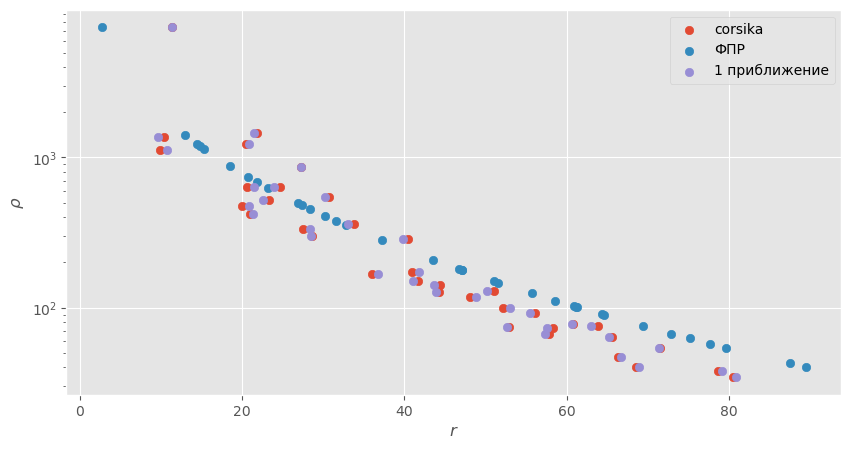

In [292]:
r_opt = compute_r(X0_opt, Y0_opt, Z0, theta, phi, coordinates_df)
r_corsika = compute_r(X0_corsika, Y0_corsika, Z0, theta, phi, coordinates_df)
rho_fit = rho_model(r_opt, Ne_opt, s_opt)

plt.figure(figsize=(10, 5))
plt.scatter(r_corsika, rho, label="corsika")

plt.scatter(r_opt, rho_fit, label="ФПР")

plt.scatter(r, rho, label="1 приближение")
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

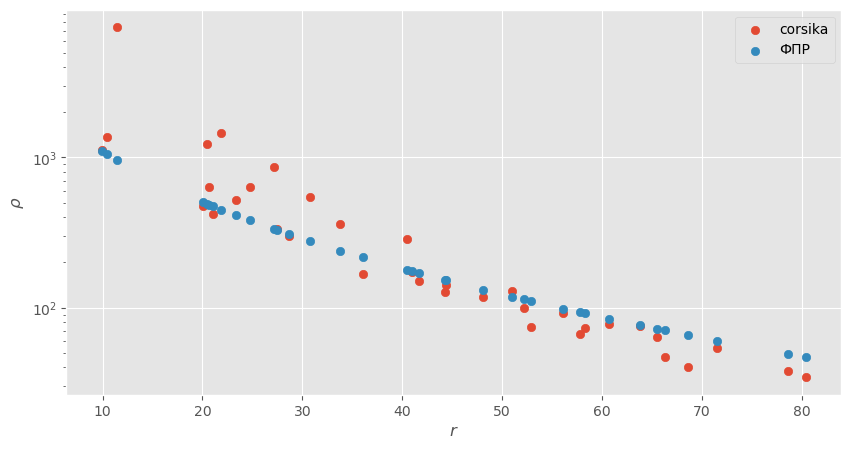

In [293]:
rho_corsika_fit = rho_model(r_corsika, Ne_corsika, s_corsika)

plt.figure(figsize=(10, 5))
plt.scatter(r_corsika, rho, label="corsika")

plt.scatter(r_corsika, rho_corsika_fit , label="ФПР")

plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.legend()
plt.show()

In [232]:
print(f'{X0_corsika:.3f}, {X0:.3f}, {X0_opt:.3f}')
print(f'{Y0_corsika:.3f}, {Y0:.3f}, {Y0_opt:.3f}')

print(f"Ne_corsika = {Ne_corsika:.1e}, Ne_opt = {Ne_opt:.1e}")
print(f"s_corsika = {s_corsika:.3f}, s_opt = {s_opt:.3f}")

19.855, 11.390, 15.711
32.812, 26.787, 42.455
Ne_corsika = 1.1e+07, Ne_opt = 1.3e+07
s_corsika = 1.310, s_opt = 1.200


In [233]:
r_opt_array = []
r_corsika_array = []

Ne_opt_array = []
s_opt_array = []

rho_corsika_array = []

In [235]:
for j_event, event in tqdm(df.iterrows(), total=len(df), desc='~'):

    E_1_event = df['EdepStNE'].iloc[j_event]

    theta = df['Teta'].iloc[j_event]
    phi = df['Fi'].iloc[j_event]

    X0_corsika = df['XAxisShift'].iloc[j_event]
    Y0_corsika = df['YAxisShift'].iloc[j_event]

    Ne_corsika = df['NeNKGlong'].iloc[j_event]
    s_corsika = df['sNKGlong'].iloc[j_event]

    X = coordinates_df['X']
    Y = coordinates_df['Y']
    Z = coordinates_df['Z']

    e_list = []
    for i_cluster, cluster in enumerate(E_1_event):
        for j_station, value in enumerate(cluster):
            e_list.append(
                {'cluster': i_cluster+1, 'station': j_station+1, 'E': value})

    E_stations = pd.DataFrame(e_list)

    rho = (E_stations['E'] / 8.2) / (0.8 * 0.8 * 4)

    result = minimize(loss_function, initial_params, args=(
    coordinates_df, rho, theta, phi, Z0), bounds=bounds, method="Nelder-Mead")
    
    X0_opt, Y0_opt, Ne_opt, s_opt = result.x

    r_opt_array.append(
        compute_r(X0_opt, Y0_opt, Z0, theta, phi, coordinates_df))
    r_corsika_array.append(
        compute_r(X0_corsika, Y0_corsika, Z0, theta, phi, coordinates_df))

    Ne_opt_array.append(Ne_opt)
    s_opt_array.append(s_opt)

    rho_corsika_array.append(rho)

~: 100%|██████████| 100/100 [00:06<00:00, 16.20it/s]


In [236]:
r_opt = np.concatenate(r_opt_array)
r_corsika = np.concatenate(r_corsika_array)

rho_corsika = np.concatenate(rho_corsika_array)

In [237]:
delta_r = r_opt - r_corsika
delta_s = np.array(s_opt_array) - np.array(df['sNKGlong'])
delta_Ne = (np.array(Ne_opt_array) -
            np.array(df['NeNKGlong'])) / np.array(df['NeNKGlong'])

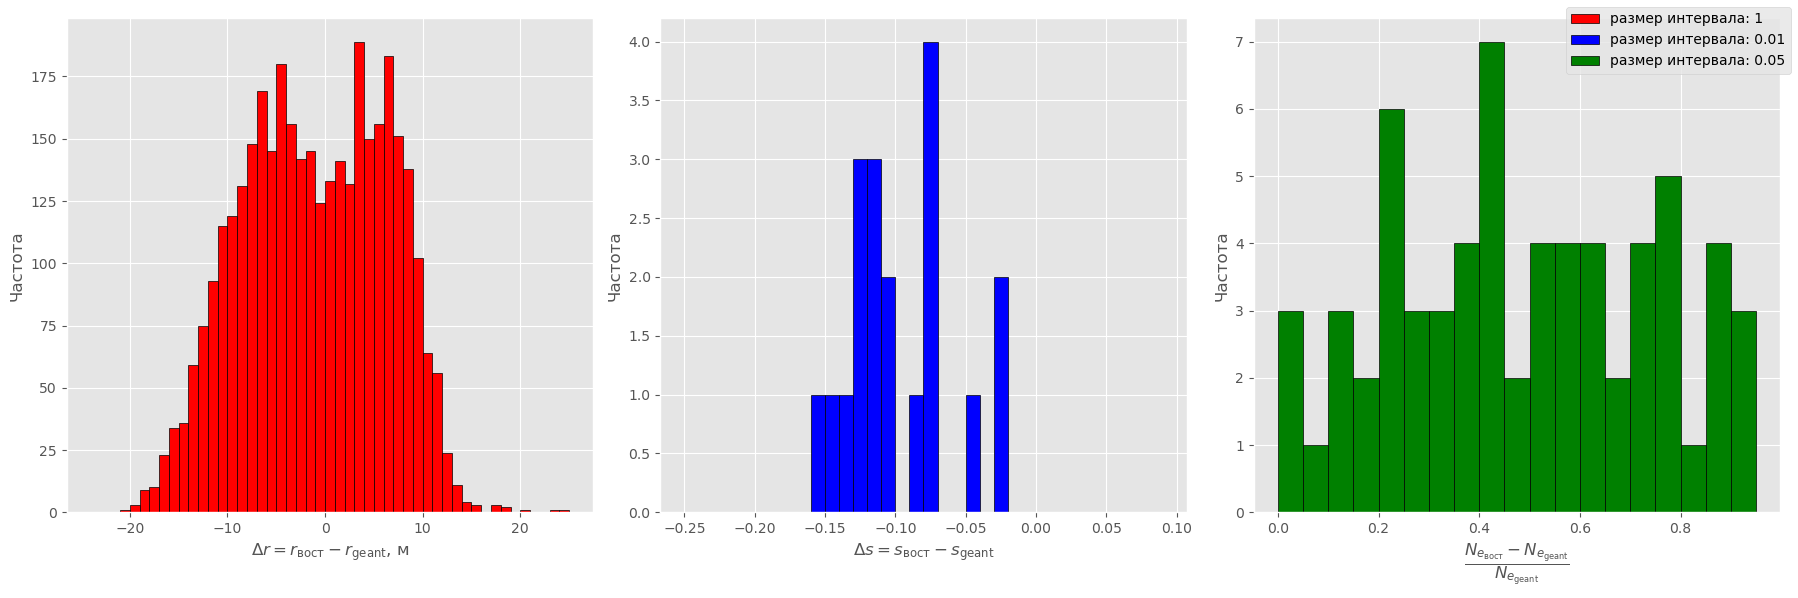

In [238]:
interval_delta_r = 1
interval_delta_s = 0.01
interval_delta_Ne = 0.05

bin_edges_delta_r = np.arange(-24, 26, interval_delta_r)
bin_edges_delta_s = np.arange(-0.25, 0.1, interval_delta_s)
bin_edges_delta_Ne = np.arange(0, 1, interval_delta_Ne)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# delta_r
axes[0].hist(delta_r, bins=bin_edges_delta_r,
             edgecolor='black', color='red', label=f'размер интервала: {interval_delta_r}')
axes[0].set_xlabel(r'$\Delta r = r_{\text{вост}} - r_{\text{geant}}$, м')
axes[0].set_ylabel("Частота")
# delta_s
axes[1].hist(delta_s, bins=bin_edges_delta_s, edgecolor='black',
             color='blue', label=f'размер интервала: {interval_delta_s}')
axes[1].set_xlabel(r'$\Delta s = s_{\text{вост}} - s_{\text{geant}}$')
axes[1].set_ylabel("Частота")

# delta_Ne
axes[2].hist(delta_Ne, bins=bin_edges_delta_Ne,
             edgecolor='black', color='green', label=f'размер интервала: {interval_delta_Ne}')
axes[2].set_xlabel(
    r'$\dfrac{N_{e_{\text{вост}}} - N_{e_{\text{geant}}}}{N_{e_{\text{geant}}}}$')
axes[2].set_ylabel("Частота")

fig.legend()

data = pd.DataFrame(
    {'delta_r': np.array(delta_r).reshape(-1, 36).tolist, 'delta_s': delta_s, 'delta_Ne': delta_Ne})
data.to_csv('plots/delta_r,s,Ne.csv', index=False)

plt.tight_layout()
plt.savefig("plots/delta_r,s,Ne.png", dpi=500, bbox_inches="tight")
plt.show()

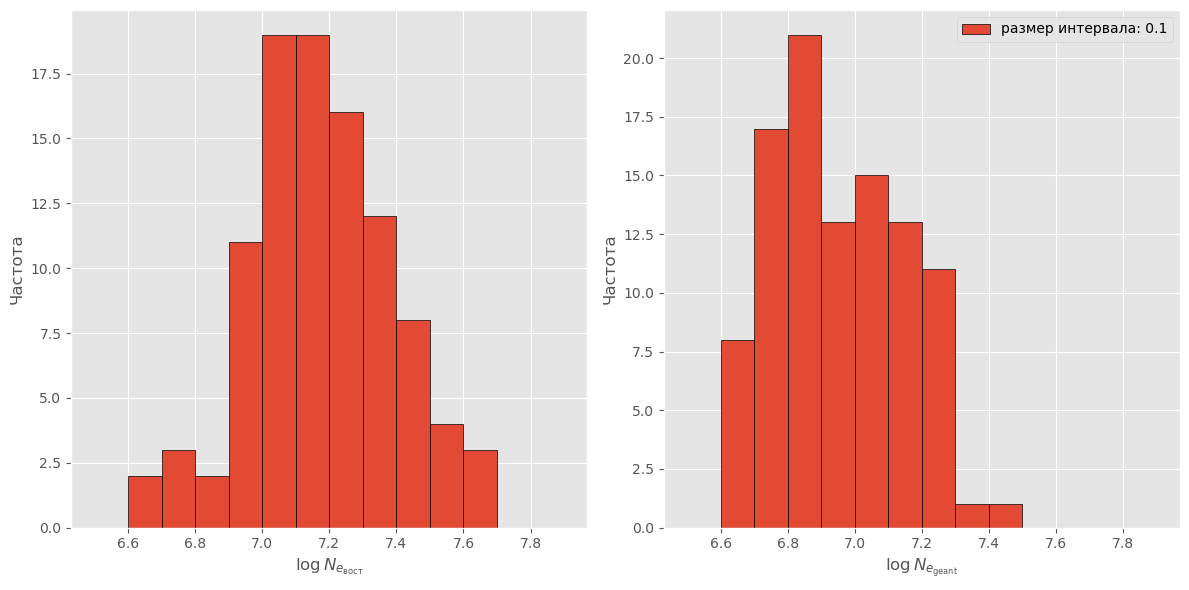

In [239]:
log_Ne_opt_array = np.log10(Ne_opt_array)
log_Ne_corsika_array = np.log10(np.array(df['NeNKGlong']))

interval_log_Ne = 0.1
bin_edges_log_Ne_opt = np.arange(6.5, 8, interval_log_Ne)
bin_edges_log_Ne_corsika = np.arange(6.5, 8, interval_log_Ne)


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# востановленный Ne
axes[0].hist(log_Ne_opt_array, bins=bin_edges_log_Ne_opt, edgecolor='black', )
axes[0].set_xlabel(r'$\log{N_{e_{\text{вост}}}}$')
axes[0].set_ylabel("Частота")

# заданный Ne
axes[1].hist(log_Ne_corsika_array,
             bins=bin_edges_log_Ne_corsika, edgecolor='black', label=f'размер интервала: {interval_log_Ne}')
axes[1].set_xlabel(r'$\log{N_{e_{\text{geant}}}}$')
axes[1].set_ylabel("Частота")
axes[1].legend()

data = pd.DataFrame(
    {'log_Ne_opt': log_Ne_opt_array, 'log_Ne_corsika': log_Ne_corsika_array})
data.to_csv('plots/log_Ne.csv', index=False)

plt.tight_layout()
plt.savefig("plots/log_Ne.png", dpi=500, bbox_inches="tight")

plt.show()

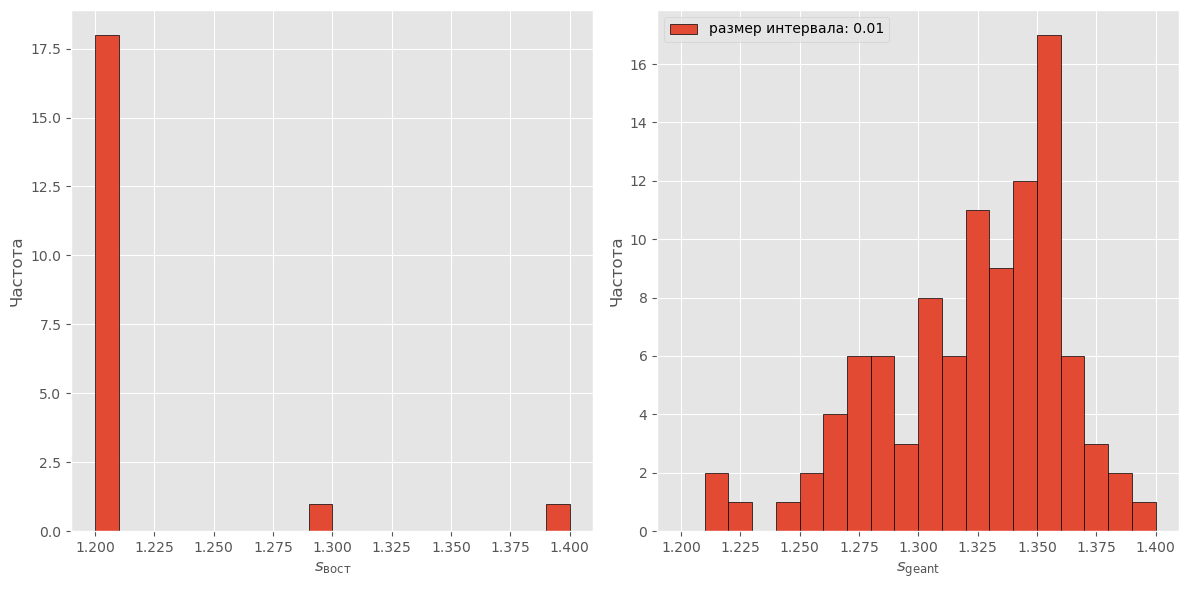

In [240]:
interval_s = 0.01

bin_edges_s_opt = np.arange(1.2, 1.41, interval_s)
bin_edges_s_corsika = np.arange(1.2, 1.41, interval_s)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# востановленный s
axes[0].hist(s_opt_array, bins=bin_edges_s_opt, edgecolor='black')
axes[0].set_xlabel(r'$s_{\text{вост}}$')
axes[0].set_ylabel("Частота")

# заданный s
axes[1].hist(df['sNKGlong'],
             bins=bin_edges_s_corsika, edgecolor='black', label=f'размер интервала: {interval_s}')
axes[1].set_xlabel(r'$s_{\text{geant}}$')
axes[1].set_ylabel("Частота")
axes[1].legend()


data = pd.DataFrame(
    {'s_opt': s_opt_array, 's_corsika': df['sNKGlong']})
data.to_csv('plots/s.csv', index=False)

plt.tight_layout()
plt.savefig("plots/s.png", dpi=500, bbox_inches="tight")

plt.show()

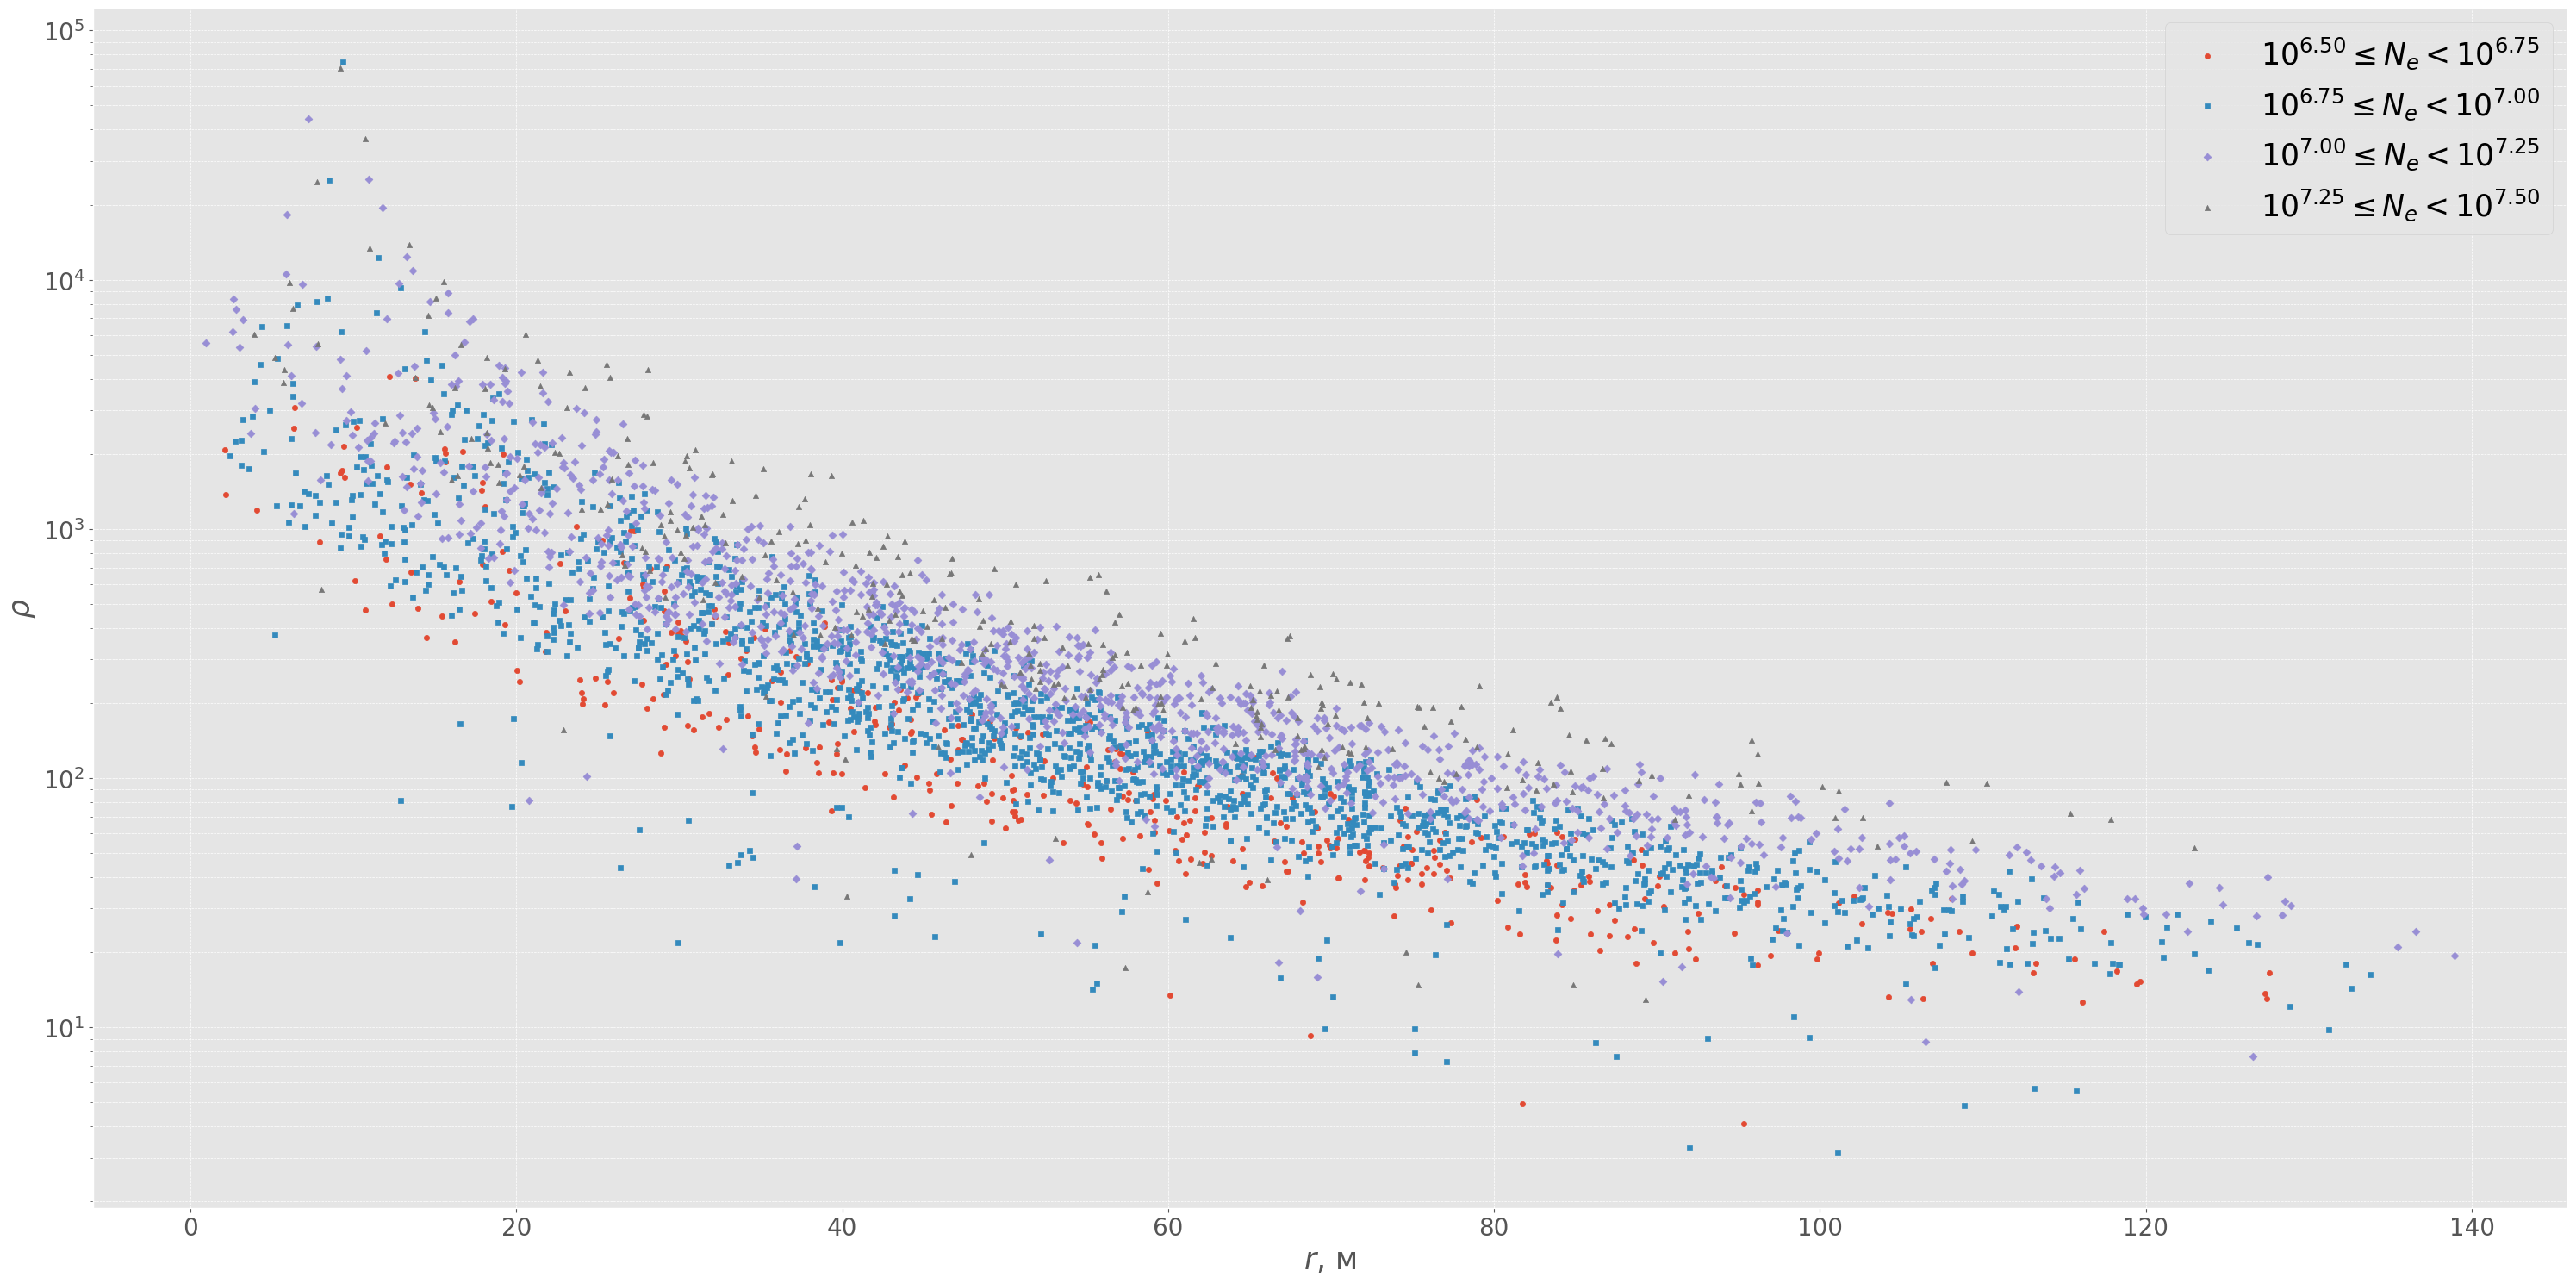

In [241]:
interval_log_Ne = 0.25
intervals = np.arange(6.5, 8, interval_log_Ne)

plt.figure(figsize=(30, 15))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'x', '+']
for i in range(len(intervals) - 1):
    lower_bound = intervals[i]
    upper_bound = intervals[i + 1]

    mask = (log_Ne_corsika_array >= lower_bound) & (
        log_Ne_corsika_array < upper_bound)

    r_interval = np.array(r_corsika_array)[mask]
    rho_interval = np.array(rho_corsika_array)[mask]

    if len(r_interval) > 0:
        r_interval = np.concatenate(r_interval)
        rho_interval = np.concatenate(rho_interval)

        marker = markers[i % len(markers)]
        plt.scatter(r_interval, rho_interval, s=20, marker=marker,
                    label=fr"$10^{{{lower_bound:.2f}}} \leq N_e < 10^{{{upper_bound:.2f}}}$")


plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$, м", fontsize=25)
plt.ylabel(r"$\rho$", fontsize=25)
plt.legend(prop={'size': 25})
plt.grid(True, which="both", linestyle="--", linewidth=0.5)


plt.tight_layout()
plt.savefig("plots/pho(r)_Ne_corsika.png", dpi=500, bbox_inches="tight")

# Показать график
plt.show()

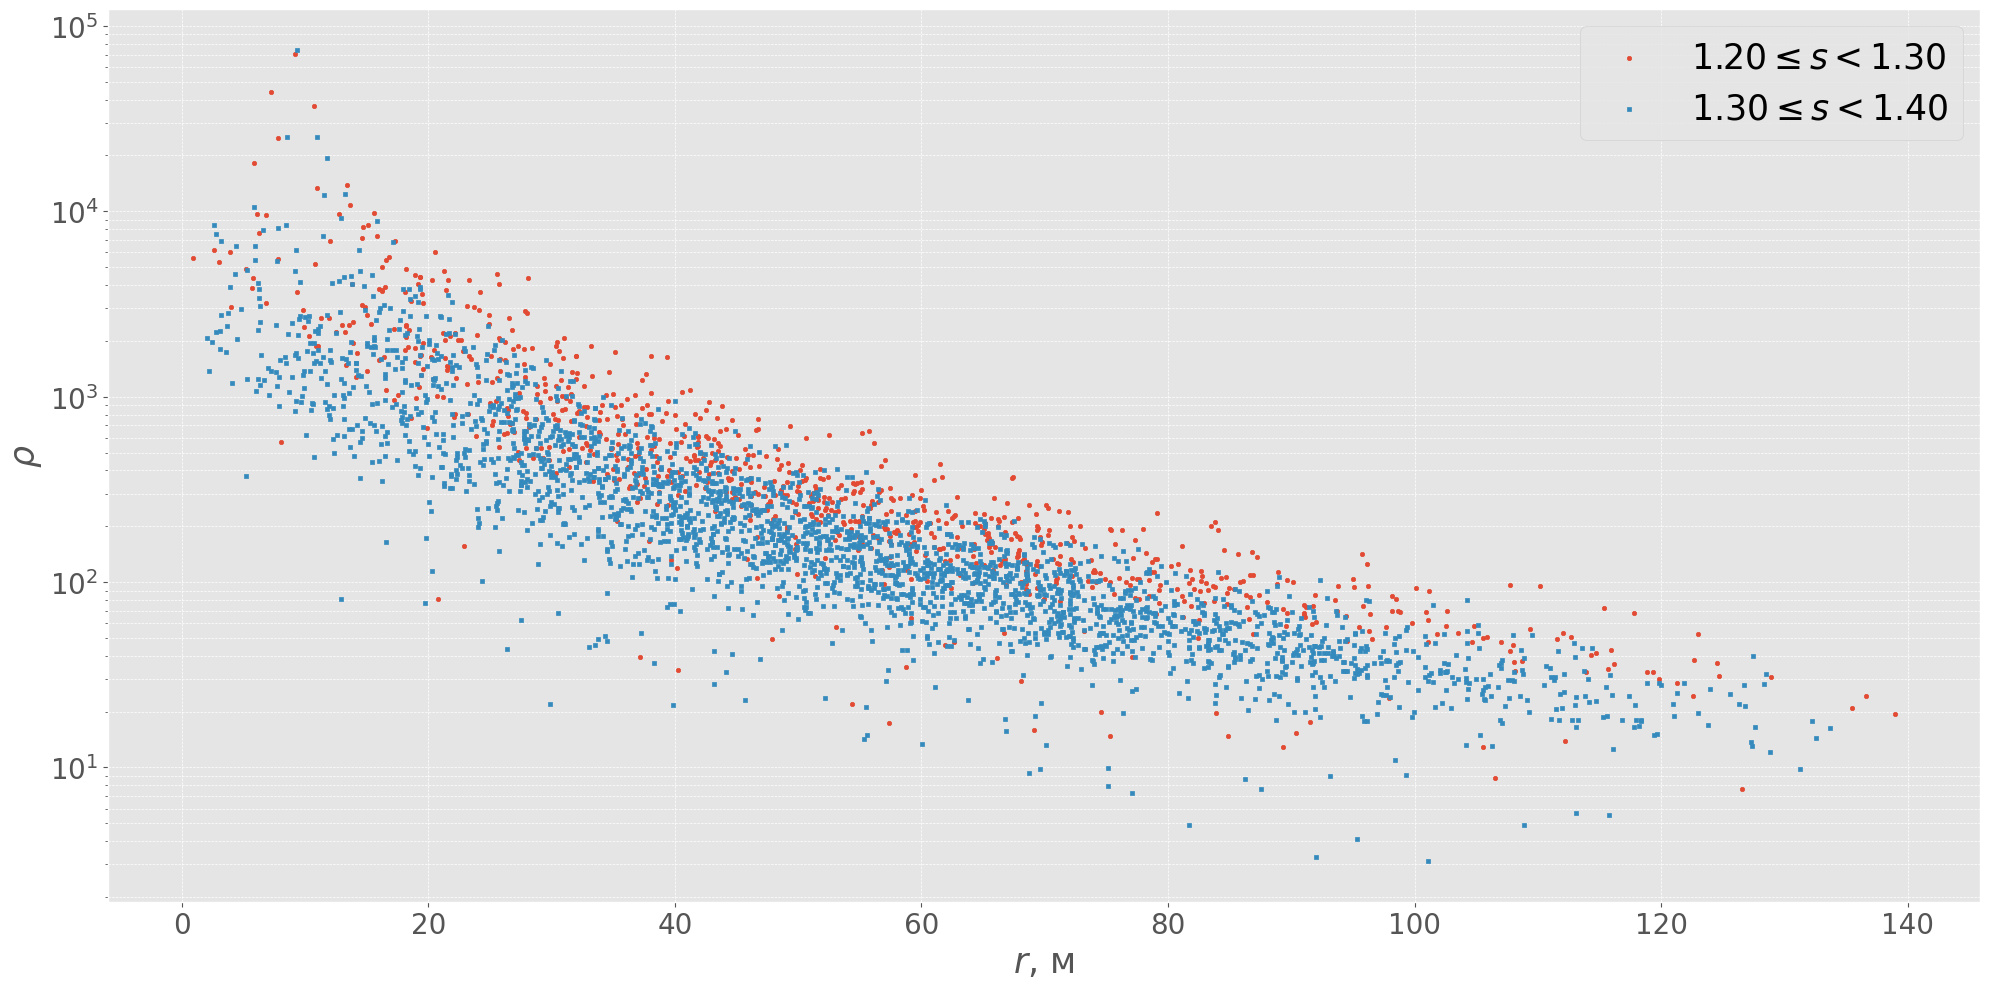

In [242]:
interval_s = 0.1
intervals = np.arange(1.2, 1.41, interval_s)
s_corsika_array = np.array(df['sNKGlong'])

plt.figure(figsize=(20, 10))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'x', '+']
for i in range(len(intervals) - 1):
    lower_bound = intervals[i]
    upper_bound = intervals[i + 1]

    mask = (s_corsika_array >= lower_bound) & (
        s_corsika_array < upper_bound)

    r_interval = np.array(r_corsika_array)[mask]
    rho_interval = np.array(rho_corsika_array)[mask]
    if len(r_interval) > 0:
        r_interval = np.concatenate(r_interval)
        rho_interval = np.concatenate(rho_interval)

        marker = markers[i % len(markers)]
        plt.scatter(r_interval, rho_interval, s=10, marker=marker,
                    label=fr"${lower_bound:.2f} \leq s < {upper_bound:.2f}$")

plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$, м", fontsize=25)
plt.ylabel(r"$\rho$", fontsize=25)
plt.legend(prop={'size': 25})
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("plots/pho(r)_s_corsika.png", dpi=500, bbox_inches="tight")

# Показать график
plt.show()

### восстановленные

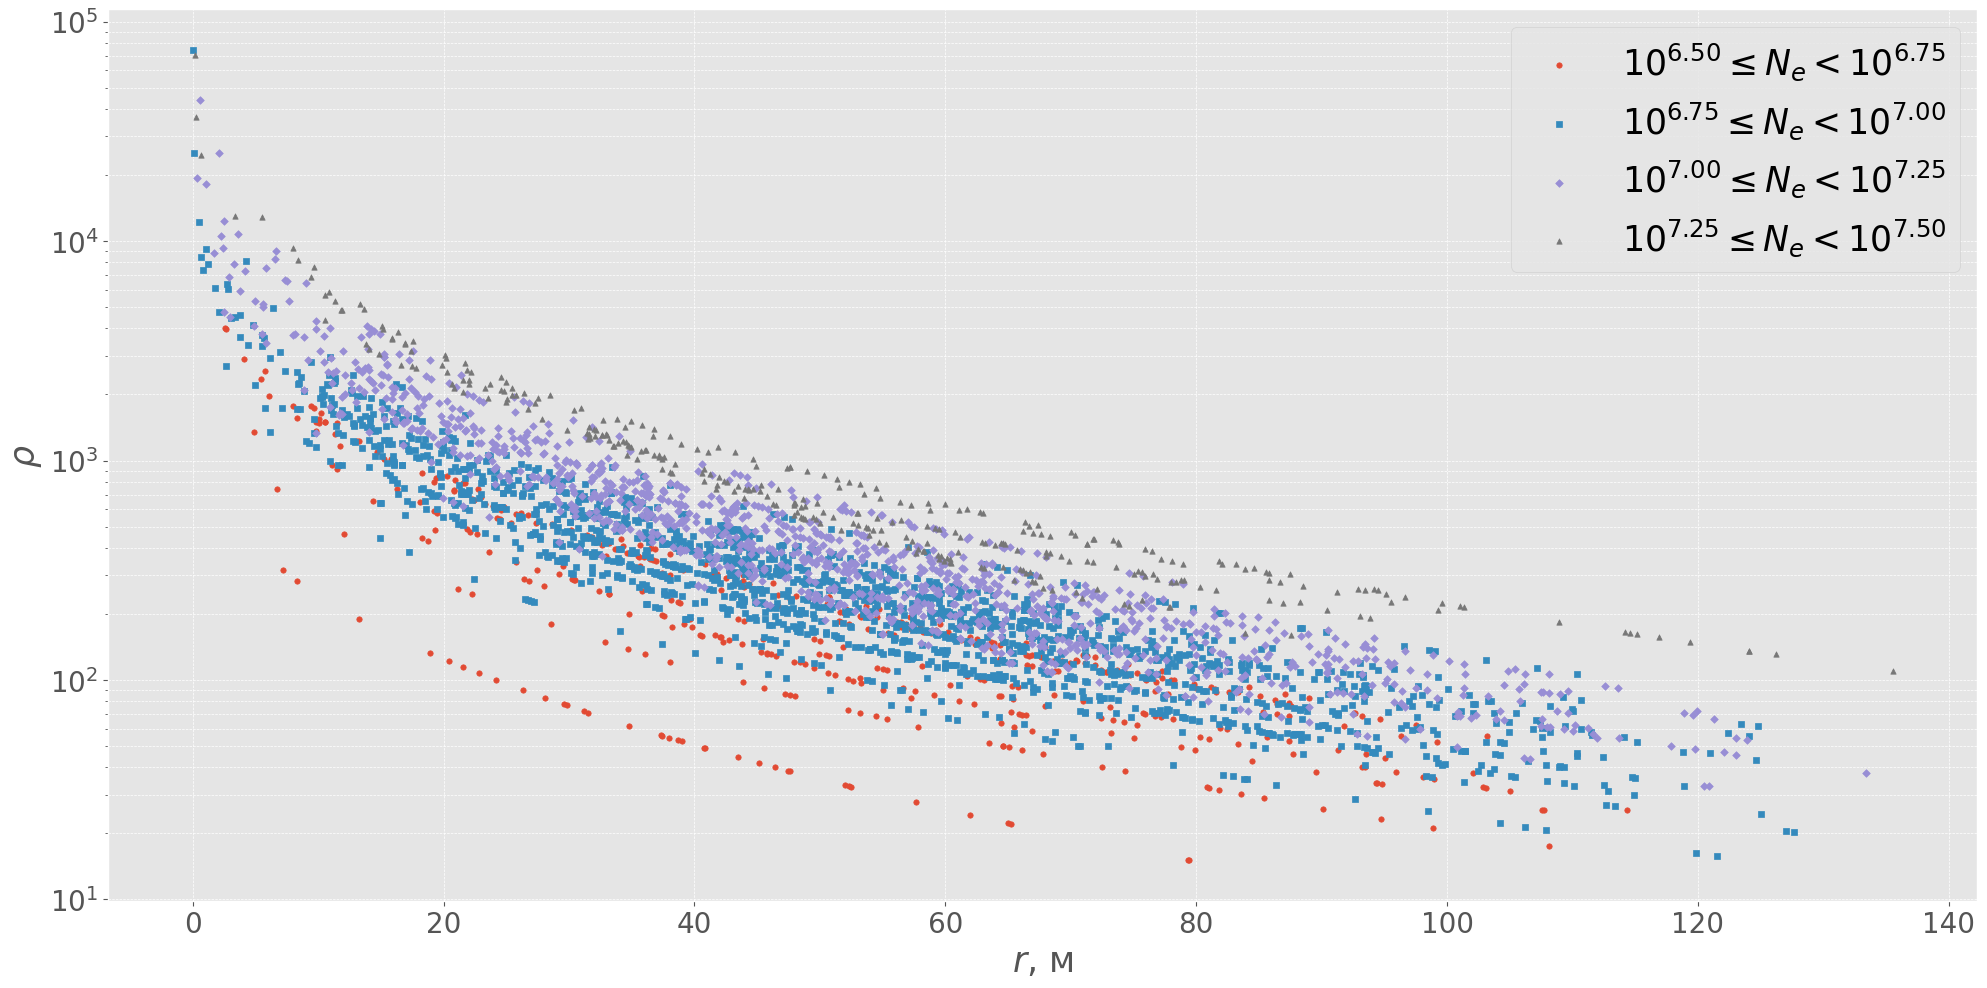

In [243]:
interval_log_Ne = 0.25
intervals = np.arange(6.5, 8, interval_log_Ne)

plt.figure(figsize=(20, 10))

markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'x', '+']
for i in range(len(intervals) - 1):
    lower_bound = intervals[i]
    upper_bound = intervals[i + 1]

    mask = (log_Ne_corsika_array >= lower_bound) & (
        log_Ne_corsika_array < upper_bound)

    r_opt = np.array(r_opt_array)[mask]
    Ne_opt = np.array(Ne_opt_array)[mask]
    s_opt = np.array(s_opt_array)[mask]

    if len(r_opt) > 0:
        rho_fit = np.array([rho_model(r_opt[i], Ne_opt[i], s_opt[i])
                           for i in range(len(r_opt))])

        r_opt = np.concatenate(r_opt)
        rho_fit = np.concatenate(rho_fit)

        marker = markers[i % len(markers)]
        plt.scatter(r_opt, rho_fit, s=15, marker=marker,
                    label=fr"$10^{{{lower_bound:.2f}}} \leq N_e < 10^{{{upper_bound:.2f}}}$")


plt.tick_params(axis='both', which='major', labelsize=20)
plt.xscale("linear")
plt.yscale("log")
plt.xlabel(r"$r$, м", fontsize=25)
plt.ylabel(r"$\rho$", fontsize=25)
plt.legend(prop={'size': 25})
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.savefig("plots/pho(r)_Ne_opt.png", dpi=500, bbox_inches="tight")
plt.show()